<a href="https://colab.research.google.com/github/efenocchi/STM32-new_project/blob/master/SuperResolutionLabCamp_(1)(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution Labcamp: Hands on Practice

## 🖼️ Image download and processing

Let's start downloading some images to test on:
- One HighQuality image (around 2000x2000 pixels)
- A second medium size image (around 800x800 pixels)

[Google](https://images.google.com/) is your friend!
Try to search something with the parameter _imagesize:800x800_

Example:

<img src="https://drive.google.com/uc?id=1qC3UKyvAqDlHAP5BjH062vFM1yo4O3ft" alt="how to look for an image on google" width="700">


In [ ]:
# examples URLs
large_image_url = 'https://www.m24o.net/wp-content/uploads/2020/09/Piedmont-Turin-Superga-8785-scaled.jpg'
medium_image_url = 'https://mymodernmet.com/wp/wp-content/uploads/2018/04/digital-collage-hybrid-animals-arne-fredriksen-7.jpg'

In [ ]:
# create the input and output folders
from pathlib import Path
INPUT_FOLDER = Path('/content/input/')
INPUT_FOLDER.mkdir(exist_ok=True)

OUTPUT_FOLDER = Path('/content/output/')
OUTPUT_FOLDER.mkdir(exist_ok=True)

ESRGAN_FOLDER = Path('/content/output/ESRGAN')
ESRGAN_FOLDER.mkdir(exist_ok=True)

REALESRGAN_FOLDER = Path('/content/output/REALESRGAN')
REALESRGAN_FOLDER.mkdir(exist_ok=True)

LINEAR_FOLDER = Path('/content/output/LINEAR')
LINEAR_FOLDER.mkdir(exist_ok=True)

# NOTE: you can directly drag local images to the input folder in the navigation panel and load them with Image.open('path/to/your/image')

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_and_display(url:str, name:str, destination_path:Path=INPUT_FOLDER):
    r = requests.get(url)
    i = Image.open(BytesIO(r.content))
    i.save(INPUT_FOLDER/f'{name}.png')
    display(i.size)
    display(i)
    return i

In [ ]:
large_image = download_and_display(large_image_url, 'large_image_original')

(750, 750)

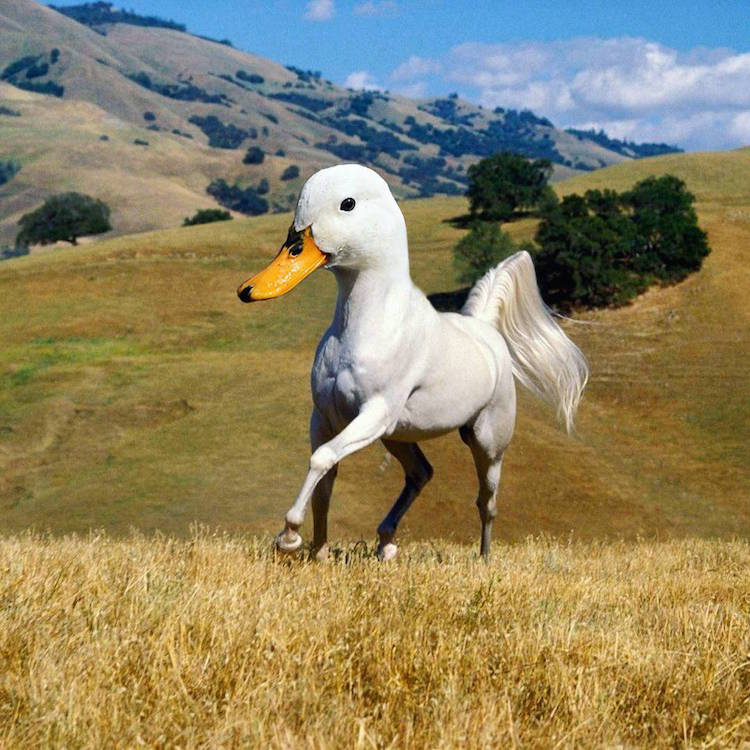

In [ ]:
medium_image = download_and_display(medium_image_url, 'medium_image_original')

In [ ]:
# Utils
import cv2
import os
import numpy as np

def bgr2rgb(image: np.ndarray):
  return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def rgb2bgr(image: np.ndarray):
  return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

def pil_to_cv2(image: Image):
    return rgb2bgr(np.array(image))

def cv2_to_pil(image: np.ndarray):
    return Image.fromarray(bgr2rgb(image))

def add_noise(clean_image: Image):
    clean_image = np.array(clean_image)
    gaussian = np.random.normal(0, 10, (clean_image.shape[0],clean_image.shape[1])) 
    noisy_image = clean_image.copy().astype(np.int32)

    noisy_image[:, :, 0] = noisy_image[:, :, 0] + gaussian 
    noisy_image[:, :, 1] = noisy_image[:, :, 1] + gaussian
    noisy_image[:, :, 2] = noisy_image[:, :, 2] + gaussian

    noisy_image[noisy_image < 0] = 0
    noisy_image[noisy_image > 255] = 255
    noisy_image = noisy_image.astype(np.uint8)
    return Image.fromarray(noisy_image)

In [ ]:
def preprocess_image(img: Image): # todo far fare agli adepti
  # normalize the image
  img = (np.array(img, dtype='float32')) / 255.  

  # change axis according to torch doc: https://pytorch.org/tutorials/intermediate/memory_format_tutorial.html
  # PyTorch convolutional layers require 4-dimensional inputs, in NCHW order. As mentioned above, N represents the batch dimension, C represents the channel dimension, H represents the image height (number of rows), and W represents the image width (number of columns).
  img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float() 

  # we need a structure like tensor[tensor_image,]
  img = img.unsqueeze(0).to(device)
  return img


def after_generation(output):
  output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
  output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
  output = (output * 255.0).round().astype(np.uint8)
  return output

def upscale_predict(img: Image):
    processed_img = preprocess_image(img)
    output = model(processed_img)
    return Image.fromarray(after_generation(output))


In [ ]:
from matplotlib import pyplot as plt
h,w = large_image.size

large_image_reduced = large_image.resize((h//4, w//4))
large_image_reduced_noisy = add_noise(large_image).resize((h//4, w//4))

print(large_image_reduced.size)

fig, axs = plt.subplots(1, 2, figsize=(40,16), constrained_layout=True)
axs[0].imshow(large_image_reduced)
axs[0].set_title("Downscaled image", fontsize=36)
axs[0].set_axis_off()

axs[1].imshow(large_image_reduced_noisy)
axs[1].set_title("Noise added", fontsize=36)
axs[1].set_axis_off()
plt.show()

large_image_reduced.save(INPUT_FOLDER/f'large_image_reduced.png')
large_image_reduced_noisy.save(INPUT_FOLDER/f'large_image_reduced_noisy.png')

------

## 🚀 ESRGAN - BasicSR inference
<a href=https://github.com/xinntao/BasicSR><img src="https://raw.githubusercontent.com/xinntao/BasicSR/master/assets/basicsr.png" width="400"></a>

### Environment set-up

In [ ]:
# Let's start cloning the official repository of BasicSR project and installind dependancies
%%capture
%cd /content
!rm -rf BasicSR
!git clone https://github.com/xinntao/BasicSR.git

# Install pytorch-vision
!pip install torch torchvision

# Install requirements
%cd /content/BasicSR
!pip install -r requirements.txt
!python setup.py develop

# Lastly we download the weight of the pretraiend model ESRGAN that we are planning to use
!python scripts/download_pretrained_models.py ESRGAN

In [ ]:
# Check torch and cuda versions
import torch
print('Torch Version: ', torch.__version__)
print('CUDA Version: ', torch.version.cuda)
print('CUDNN Version: ', torch.backends.cudnn.version())
print('CUDA Available:', torch.cuda.is_available())

Torch Version:  1.13.1+cu116
CUDA Version:  11.6
CUDNN Version:  8302
CUDA Available: True


### Prepare the model

In [ ]:
%cd /content/BasicSR/
from basicsr.archs.rrdbnet_arch import RRDBNet
import cv2
import glob
import numpy as np
import os
import torch

# load model and weights
model_path = os.path.join('experiments', 'pretrained_models', 'ESRGAN/ESRGAN_PSNR_SRx4_DF2K_official-150ff491.pth')

model = RRDBNet(
    num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32) # todo understand the hyperparam of the model

model.load_state_dict(torch.load(model_path)['params'], strict=True)
model.eval()

# send model to GPU (if availlable)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(device)

model = model.to(device)

/content/BasicSR


### Predict on downscaled images

In [ ]:
# inference
with torch.no_grad():
    prediction_clean = upscale_predict(large_image_reduced)
bicubic_upsclaed_image = large_image_reduced.resize((large_image.size[0],large_image.size[1]))

print(prediction_clean.size)

fig, axs = plt.subplots(1, 3, figsize=(40,16), constrained_layout=True)
axs[0].imshow(large_image)
axs[0].set_title("Original image", fontsize=36)
axs[0].set_axis_off()

axs[1].imshow(prediction_clean)
axs[1].set_title("Esrgan upsclaed image", fontsize=36)
axs[1].set_axis_off()

axs[2].imshow(bicubic_upsclaed_image)
axs[2].set_title("Interpoled upscaled image", fontsize=36)
axs[2].set_axis_off()
plt.show()

prediction_clean.save(ESRGAN_FOLDER/f'large_image_reduced_noisy_ERSGAN.png')
bicubic_upsclaed_image.save(LINEAR_FOLDER/f'large_image_reduced_noisy_LINEAR.png')

In [ ]:
# inference
with torch.no_grad():
    prediction_noisy = upscale_predict(large_image_reduced_noisy)
bicubic_upsclaed_image = large_image_reduced_noisy.resize((large_image.size[0],large_image.size[1]))

print(prediction_clean.size)

fig, axs = plt.subplots(1, 3, figsize=(40,16), constrained_layout=True)
axs[0].imshow(large_image_reduced_noisy)
axs[0].set_title("Noisy Original", fontsize=36)
axs[0].set_axis_off()

axs[1].imshow(prediction_noisy)
axs[1].set_title("Upscaled noisy image ESRGAN", fontsize=36)
axs[1].set_axis_off()

axs[2].imshow(large_image_reduced_noisy.resize((large_image.size[0],large_image.size[1])))
axs[2].set_title("Upscaled noisy image BCUBIC", fontsize=36)
axs[2].set_axis_off()
plt.show()

prediction_noisy.save(ESRGAN_FOLDER/f'large_image_reduced_noisy_ERSGAN.png')
large_image_reduced.save(LINEAR_FOLDER/f'large_image_reduced_noisy_LINEAR.png')

### Predict on medium size image

In [ ]:
with torch.no_grad():
    prediction_medium = upscale_predict(medium_image)

prediction_medium.save(ESRGAN_FOLDER/f'medium_image_ERSGAN.png')
prediction_medium

## 👑 REAL ESRGAN - Real world ready inference
<a href=https://github.com/xinntao/Real-ESRGAN><img src="https://github.com/xinntao/Real-ESRGAN/raw/master/assets/realesrgan_logo.png" width="400"></a>

### Environment set-up

In [ ]:
%%capture
%cd /content
# Cloning the repository
!rm -rf Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
!pip install basicsr
!pip install facexlib
!pip install gfpgan

%cd /content/Real-ESRGAN
!pip install -r requirements.txt
!python setup.py develop
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

### Preparing the model

In [ ]:
import cv2
import glob
import os
import numpy as np
import torch
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact



In [ ]:

import cv2
import glob
import numpy as np
import os
import torch

# load model and weights
model_path = os.path.join('experiments', 'pretrained_models', 'RealESRGAN_x4plus.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
loadnet = torch.load(model_path, map_location=torch.device('cpu'))


model.load_state_dict(loadnet['params_ema'], strict=True)
model.eval()
# send model to GPU (if availlable)
# device = torch.device(device)

model = model.to(device)

### Medium image inference

In [ ]:
with torch.no_grad():
  real_output_medium = upscale_predict(medium_image)


In [ ]:
real_output_medium

In [ ]:
real_output_medium.save(REALESRGAN_FOLDER / "medium_image_REAL_ESRGAN.png")

### Large image inference

In [ ]:
with torch.no_grad():
  real_output_large = upscale_predict(large_image_reduced)
  real_output_large_noisy = upscale_predict(large_image_reduced_noisy)

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(40,16), constrained_layout=True)
axs[0].imshow(real_output_large)
axs[0].set_title("Upscaled clean image", fontsize=36)
axs[0].set_axis_off()

axs[1].imshow(real_output_large_noisy)
axs[1].set_title("Upscaled noisy image", fontsize=36)
axs[1].set_axis_off()

prediction_noisy.save(REALESRGAN_FOLDER/f'large_image_reduced_noisy_REAL_ERSGAN.png')
prediction_noisy.save(REALESRGAN_FOLDER/f'large_image_reduced_noisy_REAL_ERSGAN.png')
